## Model Training
The modeling phase of the machine learning workflow consists in defining the models to be trained, train the created models, and subsequently test each model's accuracy.

I am using Amazon Sagemaker for the training, testing, and deployment of the defined models. 

In [1]:
import os
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow
import statistics
import keras
from statistics import mean, mode, median, stdev
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Activation
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [3]:
# Constants to use for this notebook


time_words = {1:'day', 5:'week', 10:'two_weeks', 20:'month', 90:'four_months', 270:'year'}


# directory containing training and testing datasets
data_dir = join('data_1/') 
final_data_dir = join(data_dir + 'final/')
top_results_file = 'results/top_accuracy.txt'
model_directory = 'models_2/'

with open(top_results_file) as f:
    text = f.read()
    top_5 = [line for line in text.split('\n')]
    top_5 = [(p.split()[0], p.split()[1]) for p in top_5]
    

In [3]:
# Read training and testing data
data = {}
for mod, _ in top_5:
    data[mod] = {}
    m = mod.split('-')
    train_file = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/train.csv'
    test_file = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/test.csv'

    df_train = pd.read_csv(train_file, header=None)
    df_test = pd.read_csv(test_file, header=None)

    y_train = df_train[0]
    X_train = df_train.drop(labels=0, axis=1)
    y_test = df_test[0]
    X_test = df_test.drop(labels=0, axis=1)

    data[mod]['y_train'] = y_train
    data[mod]['X_train'] = X_train
    data[mod]['y_test'] = y_test
    data[mod]['X_test'] = X_test
    

### Model Definition
Under the ``source/`` directory is the file ``model.py``, which contains the definition for a class named ``BinaryClassifier``. This class defines our base ANN model for this project which hast the following structure:
1. Three parameters need to be passed to the model:
    * ``input_features``: the number of neurons to create for input (11 in this case)
    * ``output_dim``: the number of neurons in the final layer of the ANN. For a binary classifier this is 1, and the result ranges from [0,1].
2. The number of neurons in the 4 hidden layers of the model are defined as:
    * ``2*input_features``
    * ``input_features/2``
3. The forward pass of the model
    * Input layer -> Linear transform to the first hidden layer
    * Passed into Rectifier Linear Unit function
    * Dropout layer (for training only)
    * Repeat the above steps until the final hidden layer...
    * Last hidden layer -> Linear transform to the output layer
    * Sigmoid Activation Function -> Result
    

In [5]:
# Define this model's hidden layer nodes and parameters
input_dim = 11
d1 = 2*input_dim
d2 = round(input_dim/2)
d3 = 1
activation = 'sigmoid'
dropout = 0.4
epochs = 100000
lr = 0.01
batch = 1000

## Plotting live callback definition

In [10]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend(['accuracy', epoch])
        plt.show();
        
plot = PlotLearning()

In [11]:
models = []
for m, _ in top_5:
    input_layer = Input(name='the_input', shape=(input_dim,), batch_shape=(None, input_dim))
    # Add dense layers
    dense_1 = Dense(d1, activation=activation)(input_layer)
    drop_1 = Dropout(dropout)(dense_1)
    dense_2 = Dense(d2, activation=activation)(drop_1)
    drop_2 = Dropout(dropout)(dense_2)
    dense_3 = Dense(d3, activation=activation)(drop_2)

    # Add sigmoid activation layer
    y_pred = Activation('sigmoid', name='sigmoid')(dense_3)
    
    # Specify the model
    model = Model(inputs=input_layer, outputs=y_pred, name=m)
    model.output_length = lambda x: x
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    models.append(model)
    
print(models[0].summary())

Model: "270-90-10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 11)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 22)                264       
_________________________________________________________________
dropout_11 (Dropout)         (None, 22)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 138       
_________________________________________________________________
dropout_12 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 7         
_________________________________________________________________
sigmoid (Activation)         (None, 1)                 0 

### Model Training
The model training will be performed by Amazon Sagemaker. Training jobs will be created for each training dataset in the ``final/`` directory. Under ``source/`` there is a file named ``train.py``, which contains the structure for a PyTorch entry point. This is necesssary for creating estimators through Sagemaker.

In [8]:
histories = []

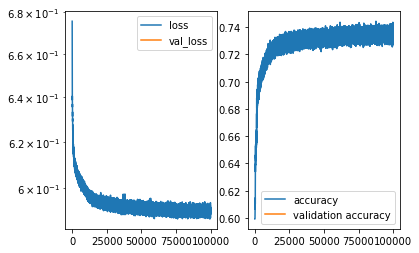

Finished training model: 270-90-10




In [8]:
model = models[0]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)

model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')

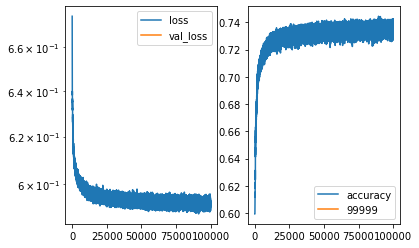

Finished training model: 270-90-270




In [12]:
model = models[1]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')

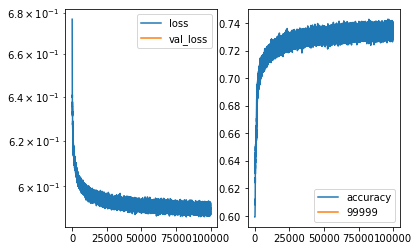

Finished training model: 90-270-10




In [22]:
model = models[2]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')
allDone()

In [24]:
model = models[3]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')
allDone()

KeyboardInterrupt: 

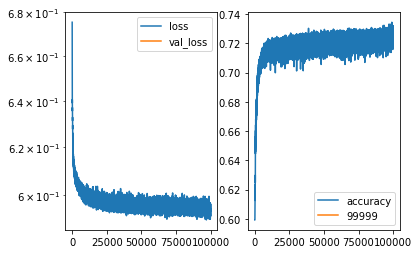

Finished training model: 20-10-270




In [25]:
model = models[4]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')
allDone()

In [ ]:
# for model in models:
#     name = model.name
#     history = model.fit(x=X_train, 
#               y=y_train,
#               batch_size=batch,
    #               epochs=epochs,
    #               verbose=0,
#               callbacks=[plot]
#              )
#     histories.append(history)
#     model.save(model_directory+name+'.h5')
#     print('Finished training model: '+name+'\n\n')

### Model Evaluation
For evaluation I am deploying each training job created. For each estimator, a predictor endpoint is created briefly to be sent data to make predictions. For each predictor, their respective test datasets are passed. The endpoint for the predictor is then deleted. Then, accuracy calculations are made against the labeled test datasets, they are printed and stored into ``.txt`` files under the ``results/`` directory.


In [8]:
models = []
for m, _ in top_5:
    models.append(keras.models.load_model(model_directory+m+'.h5'))

In [25]:
# Read training and testing data separated by tickers
data = {}
for mod, _ in top_5:
    data[mod] = {}
    data[mod]['train'] = {}
    data[mod]['test'] = {}
    m = mod.split('-')
    directory_tr = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/train/'
    directory_ts = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/test/'
    
    for filename in os.listdir(directory_tr):
        df = pd.read_csv(directory_tr+filename, header=None).iloc[::-1]
        data[mod]['train'][filename.split('.')[0]+'_y'] = df[0]
        data[mod]['train'][filename.split('.')[0]+'_X'] = df.drop(labels=0, axis=1)
    for filename in os.listdir(directory_ts):
        df = pd.read_csv(directory_ts+filename, header=None).iloc[::-1]
        data[mod]['test'][filename.split('.')[0]+'_y'] = df[0]
        data[mod]['test'][filename.split('.')[0]+'_X'] = df.drop(labels=0, axis=1)


    
    

In [26]:
tickers_file = 'ndxt_tickers.txt'
ndxt_tickers = []
with open('data/'+tickers_file) as f:
    for ticker in f:
        ndxt_tickers.append(ticker.replace('\n', ''))

In [27]:
evaluation = {}
for model in models:
    evaluation[model.name] = {}
    
    for symbol in ndxt_tickers:
        evaluation[model.name][symbol] = []
        length = len(data[model.name]['test'][symbol+'_X'])
        data_X = data[model.name]['test'][symbol+'_X']
        data_y = data[model.name]['test'][symbol+'_y']
        
        for i in range(length):
            x = data_X[i:i+1]
            y = data_y[i:i+1]
            evaluation[model.name][symbol].append(model.evaluate(x, y, verbose=0)[1])

Evalutation for model: 270-90-10

270-90-10 ADBE
Average accuracy: 0.72
Longest accurate streak: 142


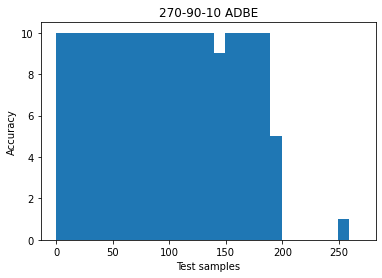

270-90-10 AMD
Average accuracy: 0.89
Longest accurate streak: 142


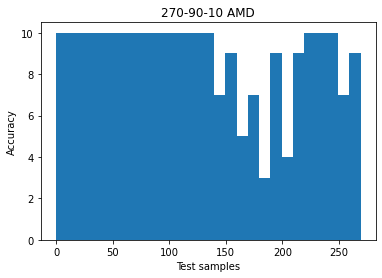

270-90-10 GOOGL
Average accuracy: 0.8
Longest accurate streak: 190


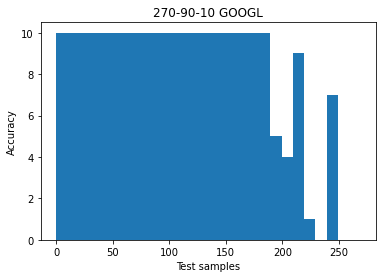

270-90-10 GOOG
Average accuracy: 0.82
Longest accurate streak: 200


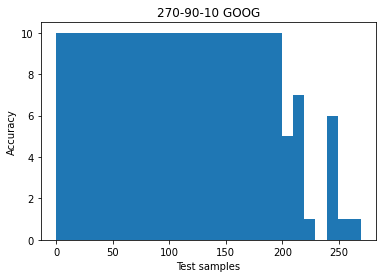

270-90-10 ADI
Average accuracy: 0.76
Longest accurate streak: 142


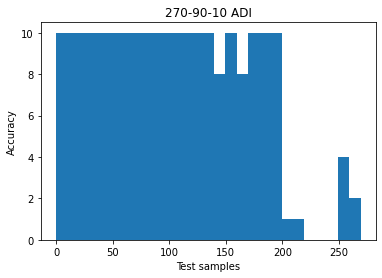

270-90-10 AAPL
Average accuracy: 0.73
Longest accurate streak: 142


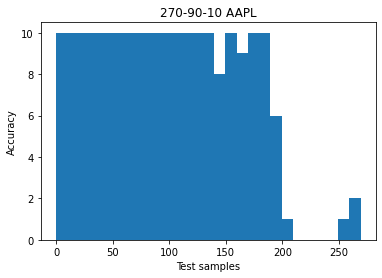

270-90-10 AMAT
Average accuracy: 0.73
Longest accurate streak: 152


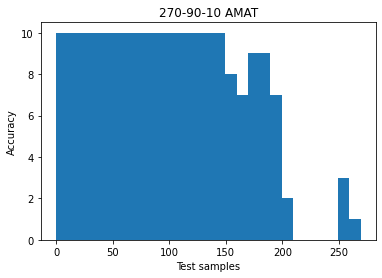

270-90-10 ASML
Average accuracy: 0.86
Longest accurate streak: 188


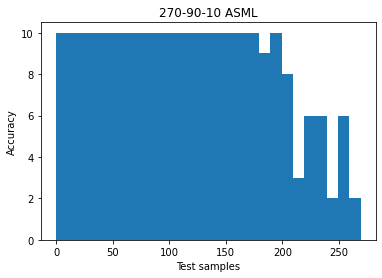

270-90-10 ADSK
Average accuracy: 0.74
Longest accurate streak: 152


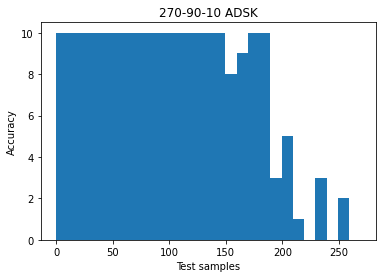

270-90-10 BIDU
Average accuracy: 0.57
Longest accurate streak: 0


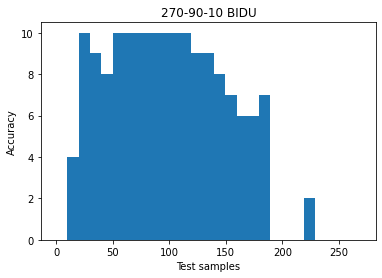

270-90-10 AVGO
Average accuracy: 0.74
Longest accurate streak: 142


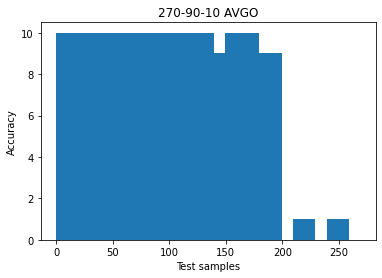

270-90-10 CDNS
Average accuracy: 0.77
Longest accurate streak: 132


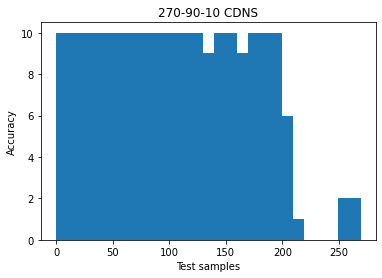

270-90-10 CERN
Average accuracy: 0.87
Longest accurate streak: 85


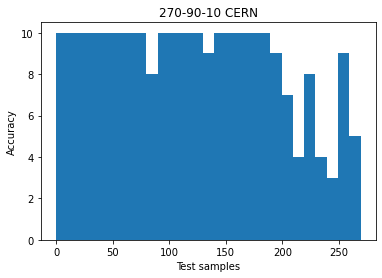

270-90-10 CHKP
Average accuracy: 0.81
Longest accurate streak: 142


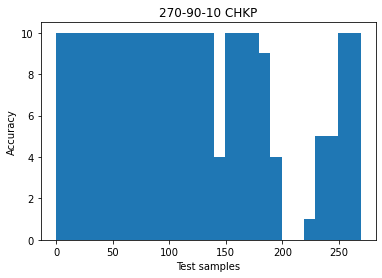

270-90-10 CSCO
Average accuracy: 0.77
Longest accurate streak: 78


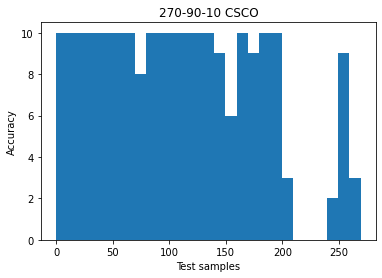

270-90-10 CTXS
Average accuracy: 0.37
Longest accurate streak: 13


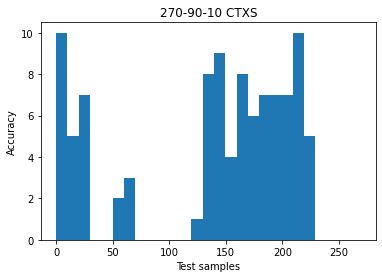

270-90-10 CTSH
Average accuracy: 0.81
Longest accurate streak: 0


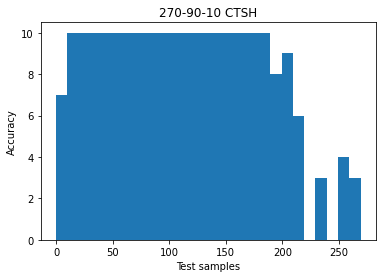

270-90-10 FB
Average accuracy: 0.71
Longest accurate streak: 141


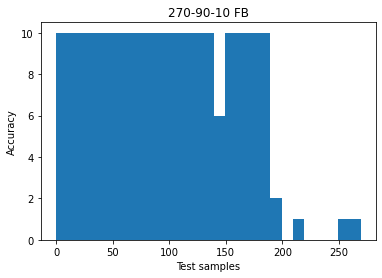

270-90-10 INTC
Average accuracy: 0.78
Longest accurate streak: 79


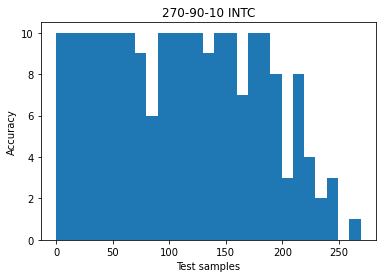

270-90-10 INTU
Average accuracy: 0.87
Longest accurate streak: 156


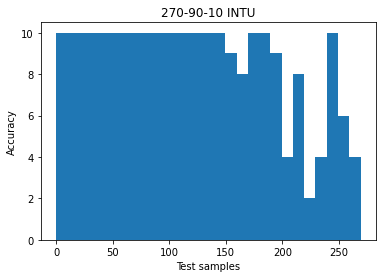

270-90-10 KLAC
Average accuracy: 0.69
Longest accurate streak: 129


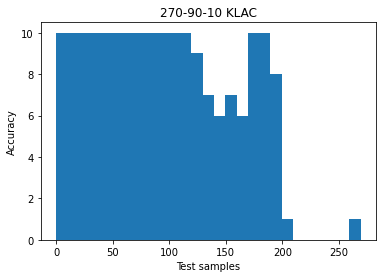

270-90-10 LRCX
Average accuracy: 0.79
Longest accurate streak: 130


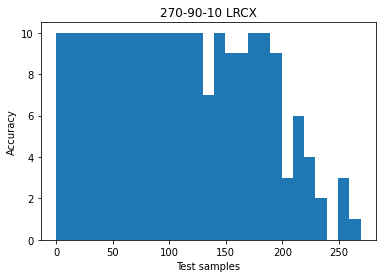

270-90-10 MXIM
Average accuracy: 0.73
Longest accurate streak: 142


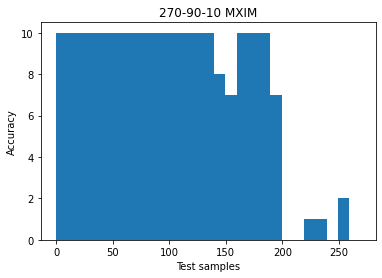

270-90-10 MCHP
Average accuracy: 0.71
Longest accurate streak: 130


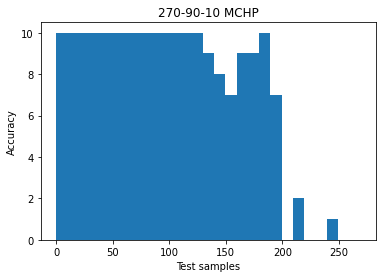

270-90-10 MU
Average accuracy: 0.79
Longest accurate streak: 143


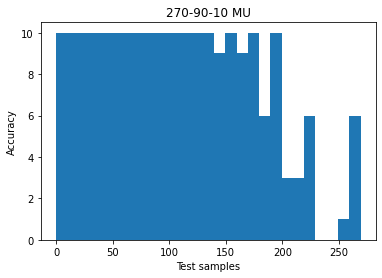

270-90-10 MSFT
Average accuracy: 0.76
Longest accurate streak: 141


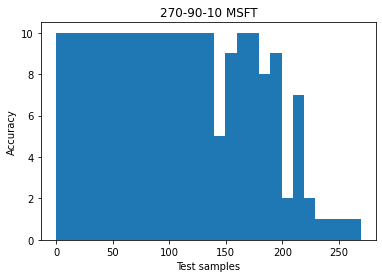

270-90-10 NTAP
Average accuracy: 0.81
Longest accurate streak: 200


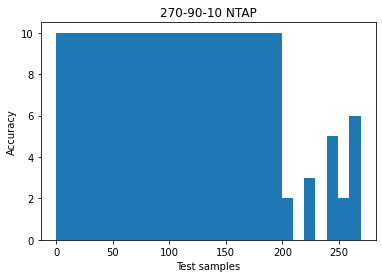

270-90-10 NTES
Average accuracy: 0.75
Longest accurate streak: 128


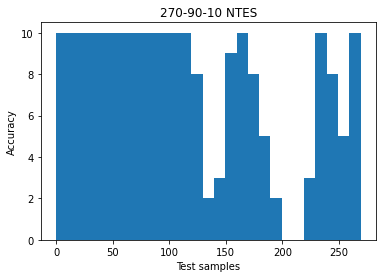

270-90-10 NVDA
Average accuracy: 0.74
Longest accurate streak: 140


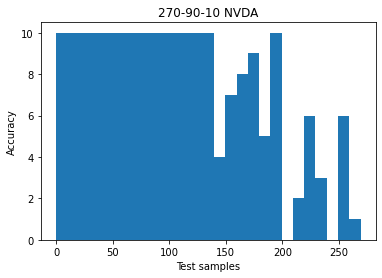

270-90-10 NXPI
Average accuracy: 0.82
Longest accurate streak: 140


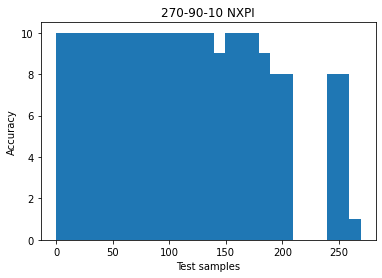

270-90-10 QCOM
Average accuracy: 0.64
Longest accurate streak: 47


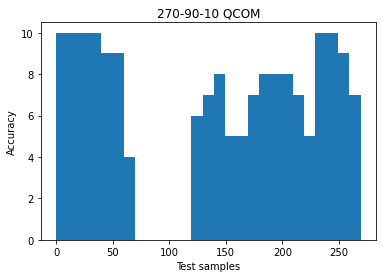

270-90-10 SWKS
Average accuracy: 0.85
Longest accurate streak: 152


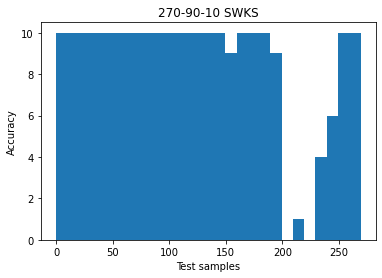

270-90-10 SYMC
Average accuracy: 0.9
Longest accurate streak: 142


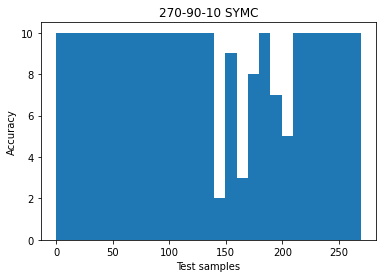

270-90-10 SNPS
Average accuracy: 0.77
Longest accurate streak: 129


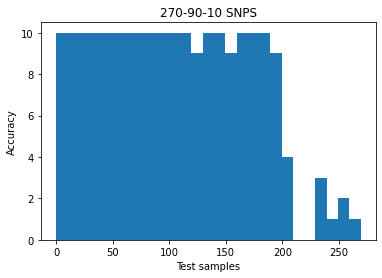

270-90-10 TXN
Average accuracy: 0.69
Longest accurate streak: 130


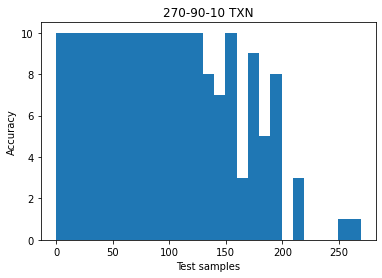

270-90-10 VRSN
Average accuracy: 0.73
Longest accurate streak: 0


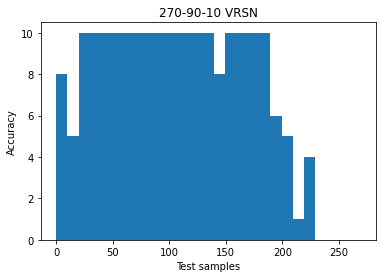

270-90-10 WDC
Average accuracy: 0.71
Longest accurate streak: 144


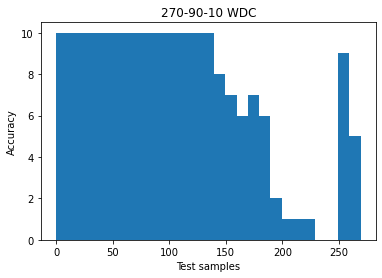

270-90-10 WDAY
Average accuracy: 0.78
Longest accurate streak: 167


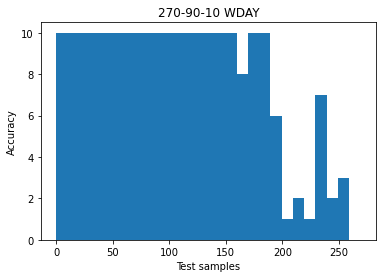

270-90-10 XLNX
Average accuracy: 0.83
Longest accurate streak: 147


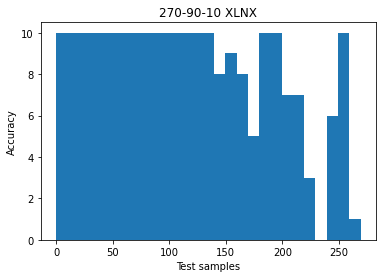

Evalutation for model: 270-90-270

270-90-270 ADBE
Average accuracy: 0.35
Longest accurate streak: 0


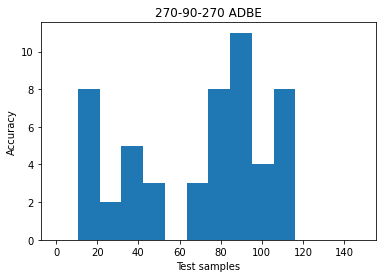

270-90-270 AMD
Average accuracy: 0.11
Longest accurate streak: 0


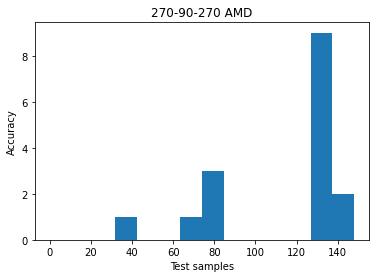

270-90-270 GOOGL
Average accuracy: 0.25
Longest accurate streak: 0


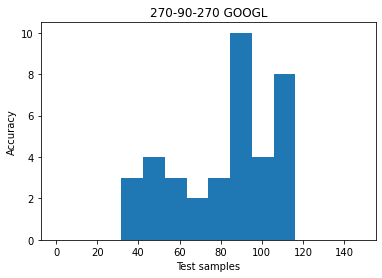

270-90-270 GOOG
Average accuracy: 0.26
Longest accurate streak: 0


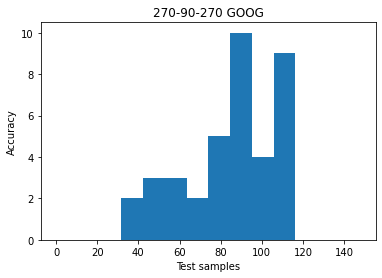

270-90-270 ADI
Average accuracy: 0.35
Longest accurate streak: 0


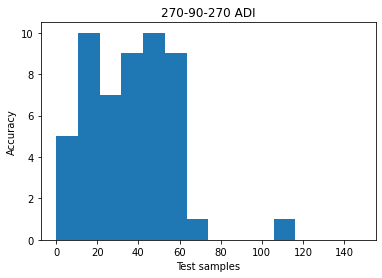

270-90-270 AAPL
Average accuracy: 0.2
Longest accurate streak: 1


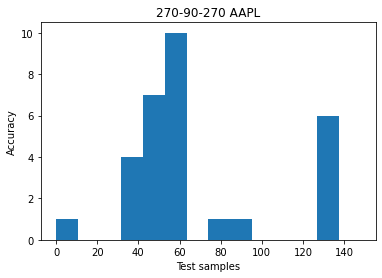

270-90-270 AMAT
Average accuracy: 1.0
Longest accurate streak: 0


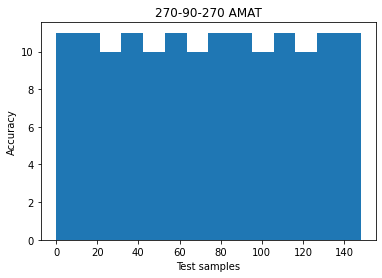

270-90-270 ASML
Average accuracy: 0.65
Longest accurate streak: 0


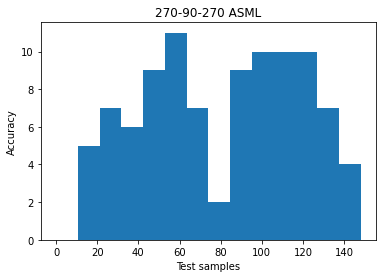

270-90-270 ADSK
Average accuracy: 0.05
Longest accurate streak: 0


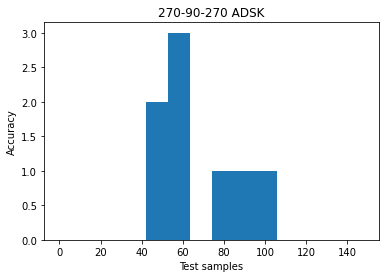

270-90-270 BIDU
Average accuracy: 1.0
Longest accurate streak: 0


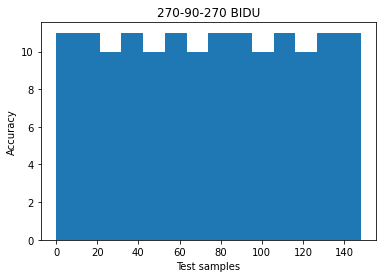

270-90-270 AVGO
Average accuracy: 0.52
Longest accurate streak: 74


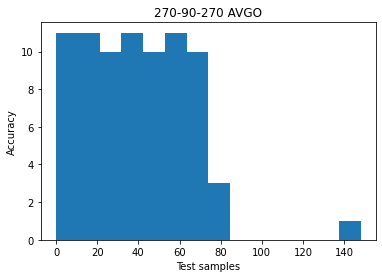

270-90-270 CDNS
Average accuracy: 0.64
Longest accurate streak: 34


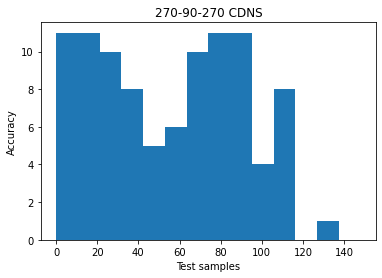

270-90-270 CERN
Average accuracy: 0.81
Longest accurate streak: 39


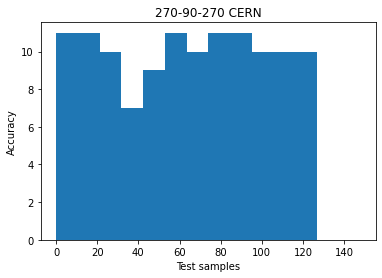

270-90-270 CHKP
Average accuracy: 0.3
Longest accurate streak: 0


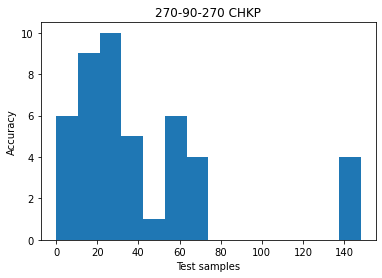

270-90-270 CSCO
Average accuracy: 0.01
Longest accurate streak: 0


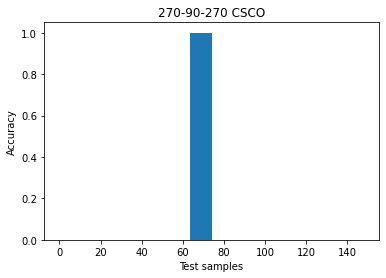

270-90-270 CTXS
Average accuracy: 0.11
Longest accurate streak: 0


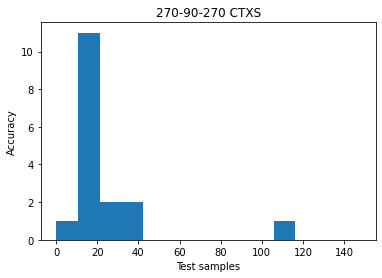

270-90-270 CTSH
Average accuracy: 0.93
Longest accurate streak: 0


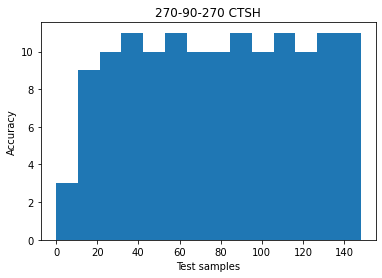

270-90-270 FB
Average accuracy: 0.87
Longest accurate streak: 107


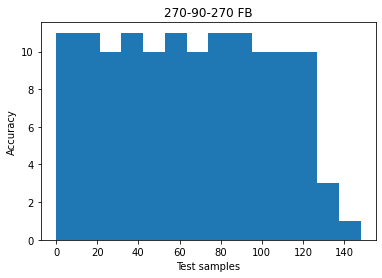

270-90-270 INTC
Average accuracy: 0.37
Longest accurate streak: 4


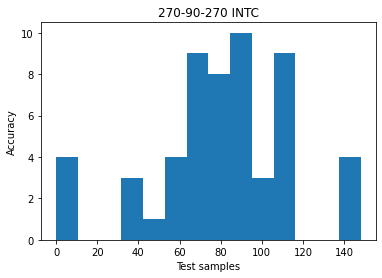

270-90-270 INTU
Average accuracy: 0.67
Longest accurate streak: 23


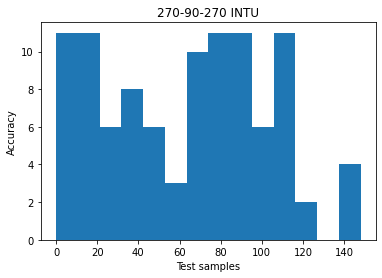

270-90-270 KLAC
Average accuracy: 0.61
Longest accurate streak: 0


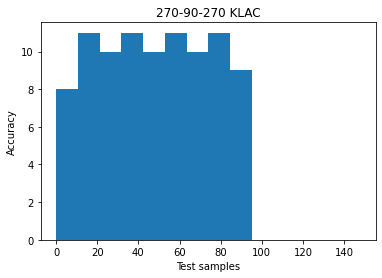

270-90-270 LRCX
Average accuracy: 0.93
Longest accurate streak: 101


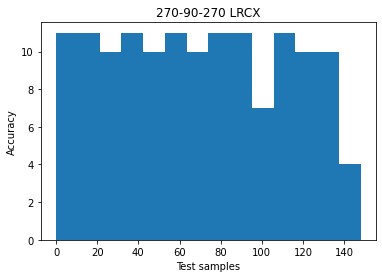

270-90-270 MXIM
Average accuracy: 0.53
Longest accurate streak: 0


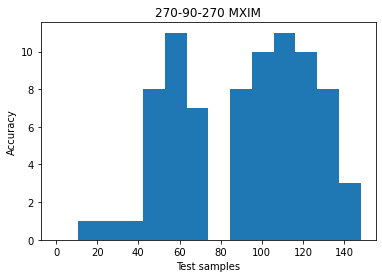

270-90-270 MCHP
Average accuracy: 0.81
Longest accurate streak: 103


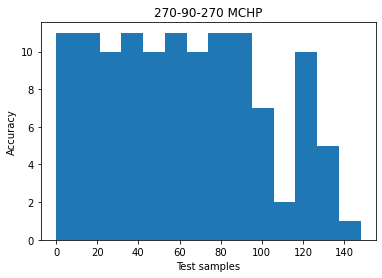

270-90-270 MU
Average accuracy: 0.88
Longest accurate streak: 0


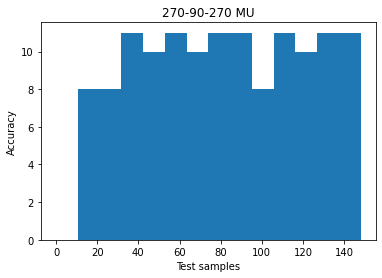

270-90-270 MSFT
Average accuracy: 0.46
Longest accurate streak: 34


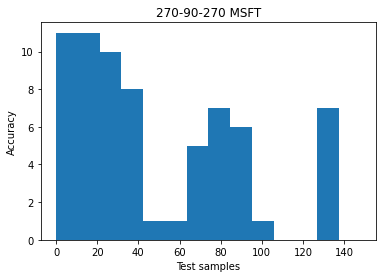

270-90-270 NTAP
Average accuracy: 0.01
Longest accurate streak: 0


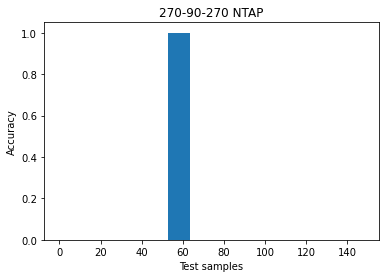

270-90-270 NTES
Average accuracy: 0.91
Longest accurate streak: 106


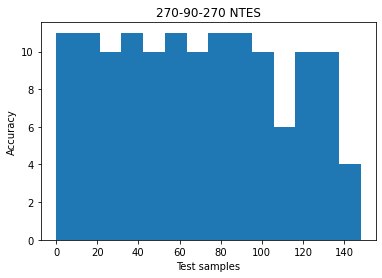

270-90-270 NVDA
Average accuracy: 0.81
Longest accurate streak: 0


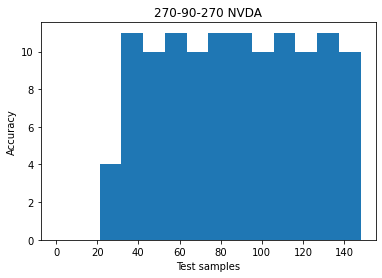

270-90-270 NXPI
Average accuracy: 0.99
Longest accurate streak: 148


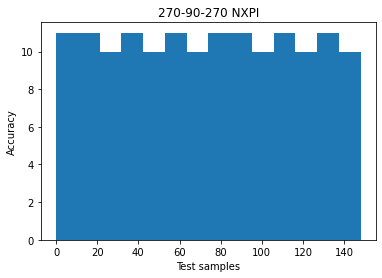

270-90-270 QCOM
Average accuracy: 0.85
Longest accurate streak: 32


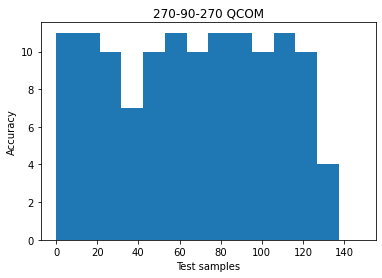

270-90-270 SWKS
Average accuracy: 0.98
Longest accurate streak: 146


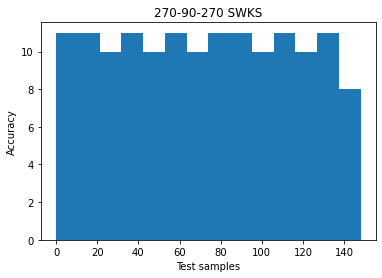

270-90-270 SYMC
Average accuracy: 0.93
Longest accurate streak: 107


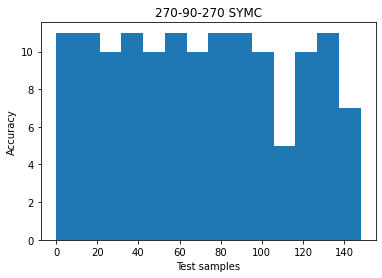

270-90-270 SNPS
Average accuracy: 0.41
Longest accurate streak: 0


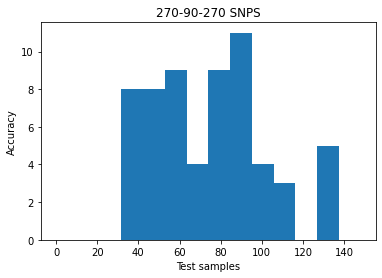

270-90-270 TXN
Average accuracy: 0.48
Longest accurate streak: 0


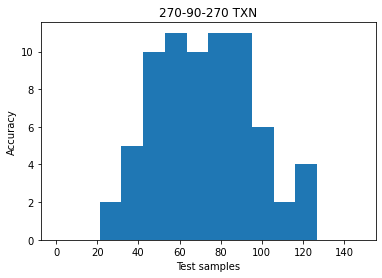

270-90-270 VRSN
Average accuracy: 0.62
Longest accurate streak: 0


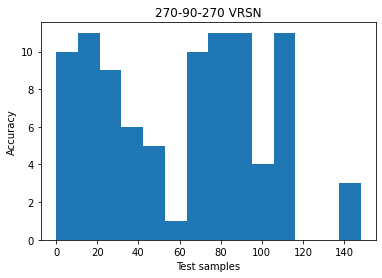

270-90-270 WDC
Average accuracy: 1.0
Longest accurate streak: 0


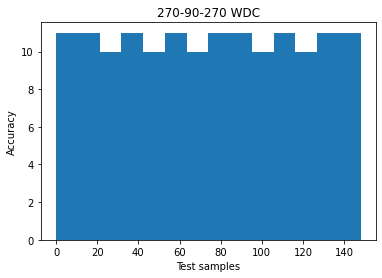

270-90-270 WDAY
Average accuracy: 0.59
Longest accurate streak: 21


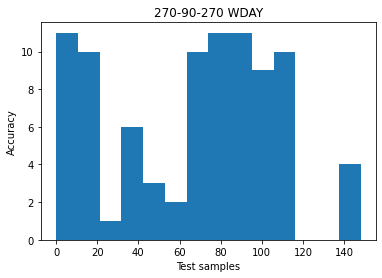

270-90-270 XLNX
Average accuracy: 0.44
Longest accurate streak: 0


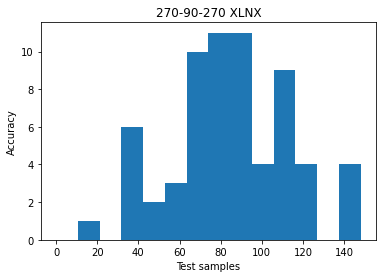

Evalutation for model: 90-270-10

90-270-10 ADBE
Average accuracy: 0.39
Longest accurate streak: 24


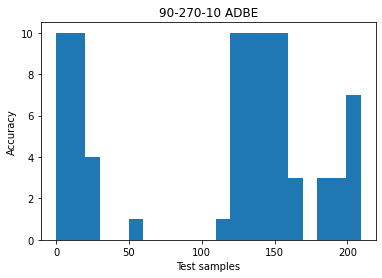

90-270-10 AMD
Average accuracy: 0.58
Longest accurate streak: 0


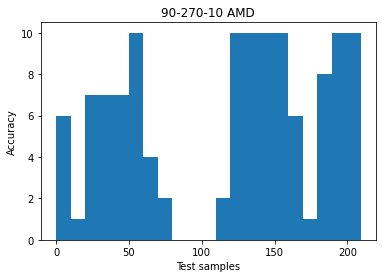

90-270-10 GOOGL
Average accuracy: 0.53
Longest accurate streak: 22


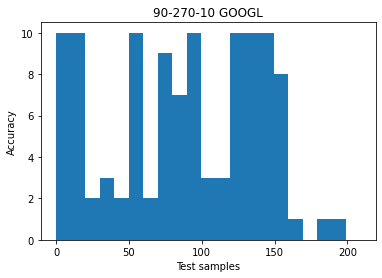

90-270-10 GOOG
Average accuracy: 0.51
Longest accurate streak: 21


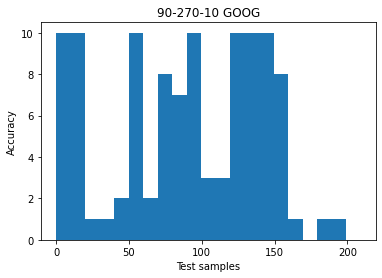

90-270-10 ADI
Average accuracy: 0.4
Longest accurate streak: 8


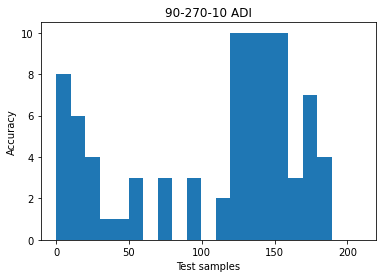

90-270-10 AAPL
Average accuracy: 0.53
Longest accurate streak: 23


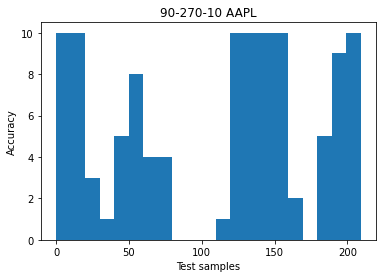

90-270-10 AMAT
Average accuracy: 0.46
Longest accurate streak: 15


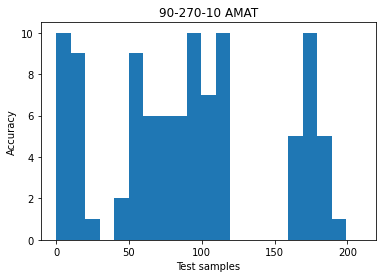

90-270-10 ASML
Average accuracy: 0.38
Longest accurate streak: 24


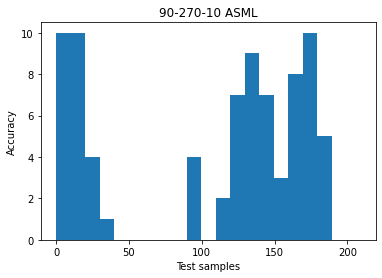

90-270-10 ADSK
Average accuracy: 0.38
Longest accurate streak: 0


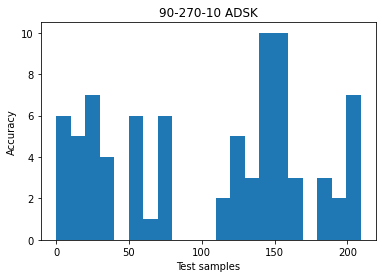

90-270-10 BIDU
Average accuracy: 0.52
Longest accurate streak: 6


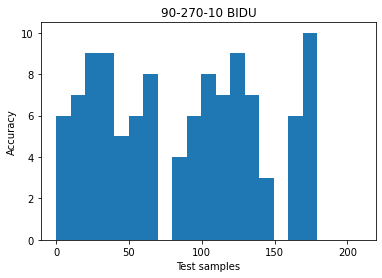

90-270-10 AVGO
Average accuracy: 0.41
Longest accurate streak: 7


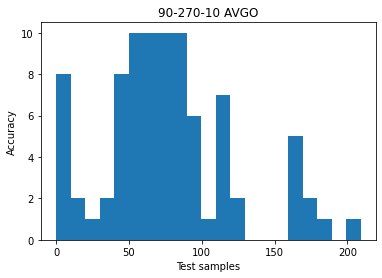

90-270-10 CDNS
Average accuracy: 0.73
Longest accurate streak: 16


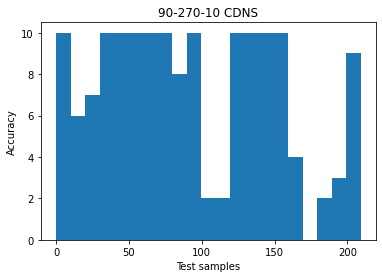

90-270-10 CERN
Average accuracy: 0.6
Longest accurate streak: 3


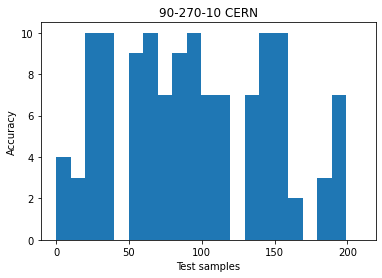

90-270-10 CHKP
Average accuracy: 0.75
Longest accurate streak: 0


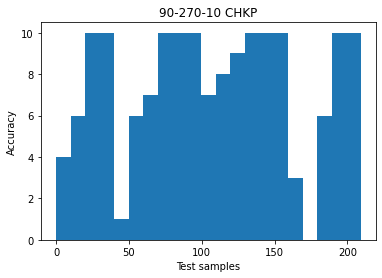

90-270-10 CSCO
Average accuracy: 0.38
Longest accurate streak: 13


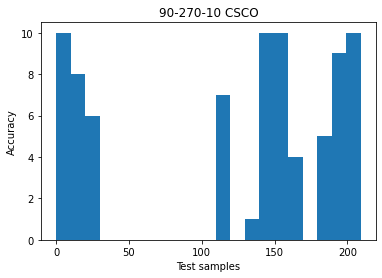

90-270-10 CTXS
Average accuracy: 0.4
Longest accurate streak: 23


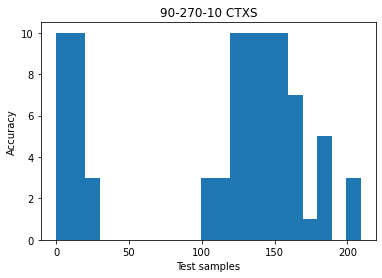

90-270-10 CTSH
Average accuracy: 0.24
Longest accurate streak: 10


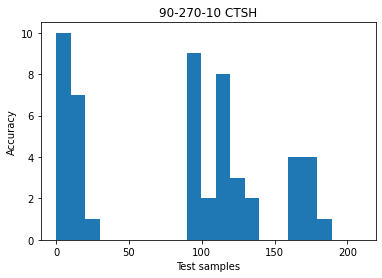

90-270-10 FB
Average accuracy: 0.6
Longest accurate streak: 23


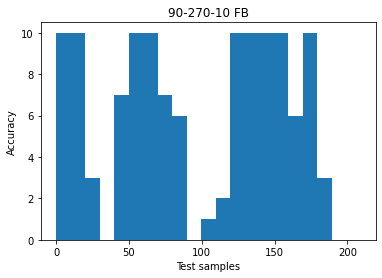

90-270-10 INTC
Average accuracy: 0.24
Longest accurate streak: 12


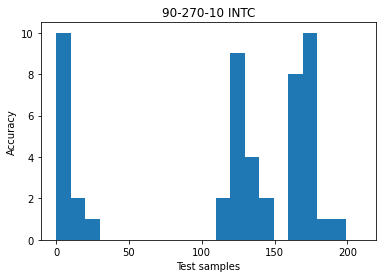

90-270-10 INTU
Average accuracy: 0.42
Longest accurate streak: 12


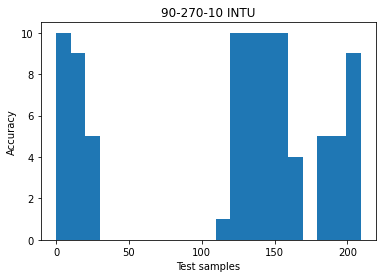

90-270-10 KLAC
Average accuracy: 0.45
Longest accurate streak: 16


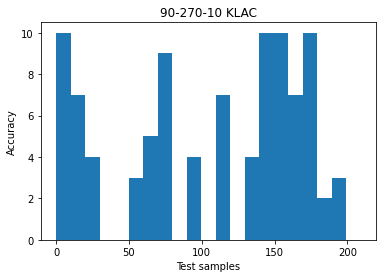

90-270-10 LRCX
Average accuracy: 0.42
Longest accurate streak: 12


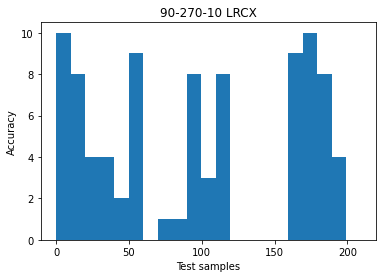

90-270-10 MXIM
Average accuracy: 0.32
Longest accurate streak: 12


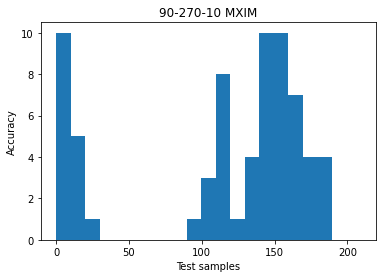

90-270-10 MCHP
Average accuracy: 0.42
Longest accurate streak: 6


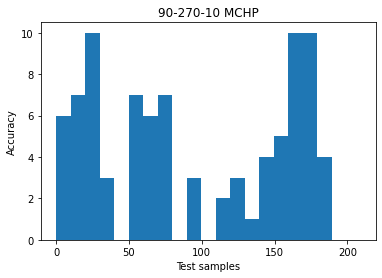

90-270-10 MU
Average accuracy: 0.32
Longest accurate streak: 9


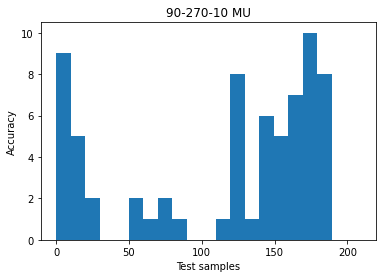

90-270-10 MSFT
Average accuracy: 0.45
Longest accurate streak: 24


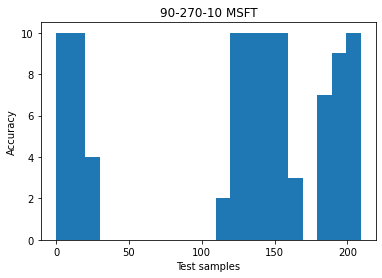

90-270-10 NTAP
Average accuracy: 0.4
Longest accurate streak: 17


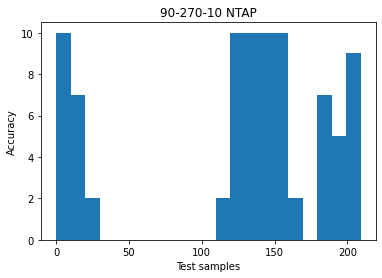

90-270-10 NTES
Average accuracy: 0.37
Longest accurate streak: 8


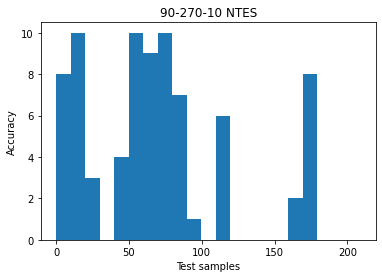

90-270-10 NVDA
Average accuracy: 0.37
Longest accurate streak: 7


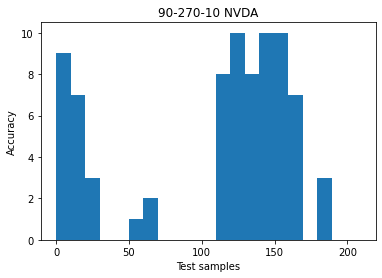

90-270-10 NXPI
Average accuracy: 0.5
Longest accurate streak: 15


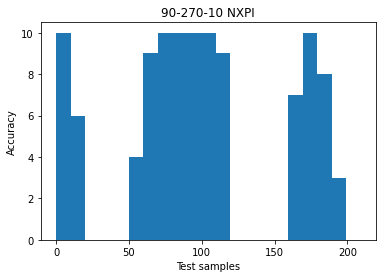

90-270-10 QCOM
Average accuracy: 0.74
Longest accurate streak: 24


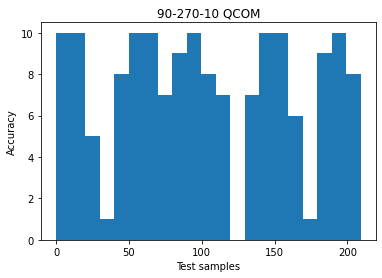

90-270-10 SWKS
Average accuracy: 0.45
Longest accurate streak: 0


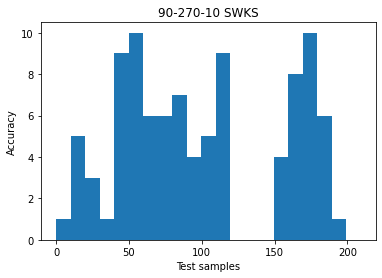

90-270-10 SYMC
Average accuracy: 0.5
Longest accurate streak: 0


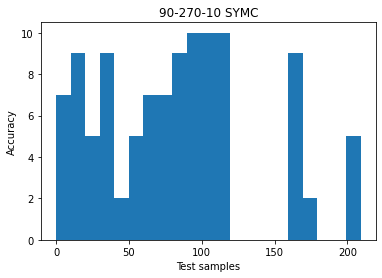

90-270-10 SNPS
Average accuracy: 0.64
Longest accurate streak: 6


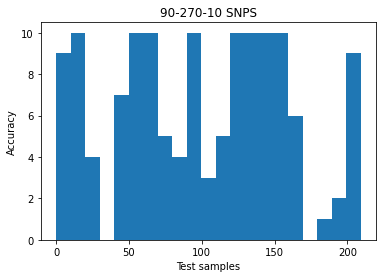

90-270-10 TXN
Average accuracy: 0.44
Longest accurate streak: 7


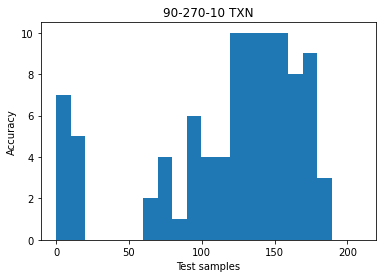

90-270-10 VRSN
Average accuracy: 0.43
Longest accurate streak: 17


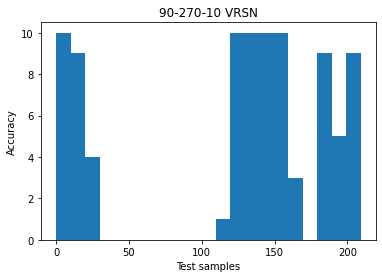

90-270-10 WDC
Average accuracy: 0.34
Longest accurate streak: 0


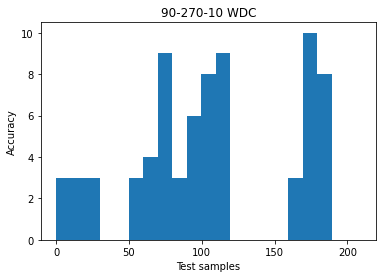

90-270-10 WDAY
Average accuracy: 0.35
Longest accurate streak: 24


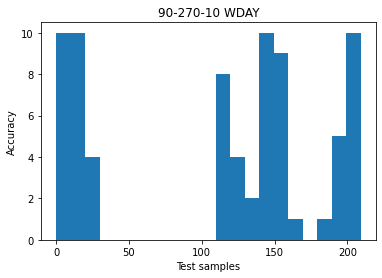

90-270-10 XLNX
Average accuracy: 0.61
Longest accurate streak: 14


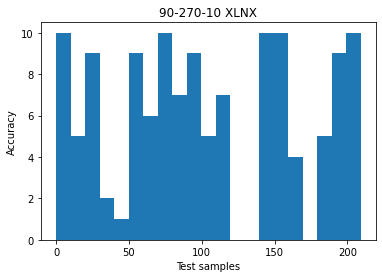

Evalutation for model: 90-270-90

90-270-90 ADBE
Average accuracy: 0.93
Longest accurate streak: 186


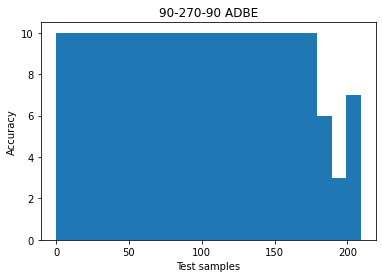

90-270-90 AMD
Average accuracy: 0.74
Longest accurate streak: 0


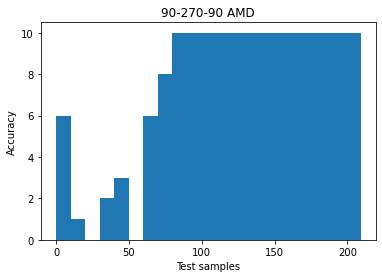

90-270-90 GOOGL
Average accuracy: 0.68
Longest accurate streak: 47


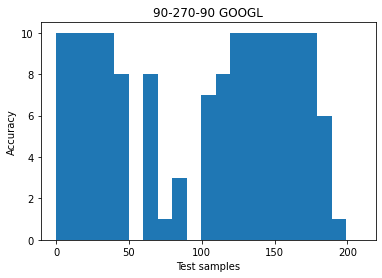

90-270-90 GOOG
Average accuracy: 0.68
Longest accurate streak: 47


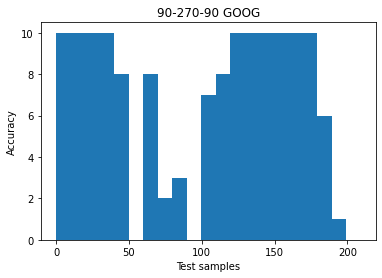

90-270-90 ADI
Average accuracy: 0.72
Longest accurate streak: 16


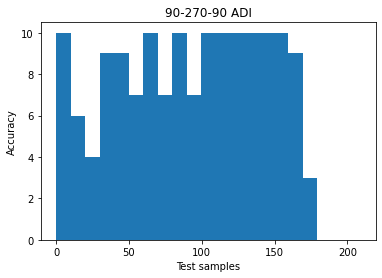

90-270-90 AAPL
Average accuracy: 0.9
Longest accurate streak: 45


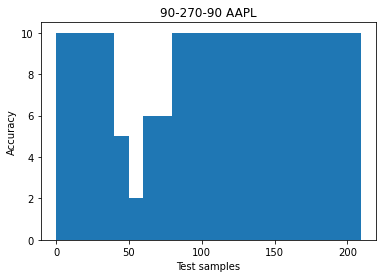

90-270-90 AMAT
Average accuracy: 0.29
Longest accurate streak: 16


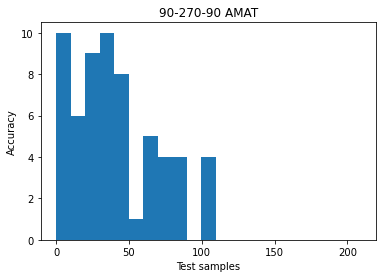

90-270-90 ASML
Average accuracy: 0.68
Longest accurate streak: 92


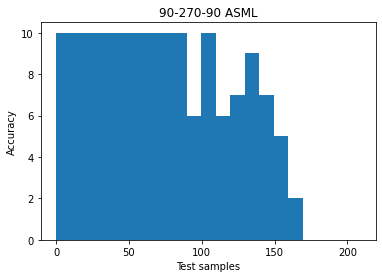

90-270-90 ADSK
Average accuracy: 0.74
Longest accurate streak: 0


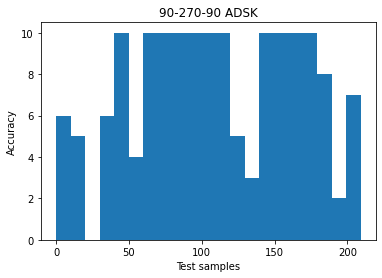

90-270-90 BIDU
Average accuracy: 0.38
Longest accurate streak: 12


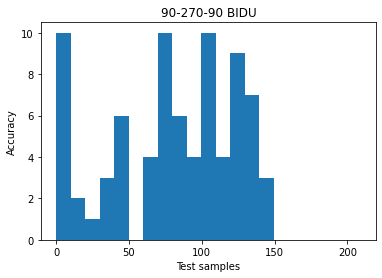

90-270-90 AVGO
Average accuracy: 0.29
Longest accurate streak: 7


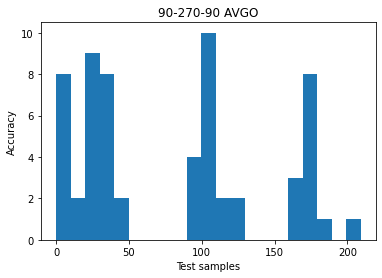

90-270-90 CDNS
Average accuracy: 0.54
Longest accurate streak: 16


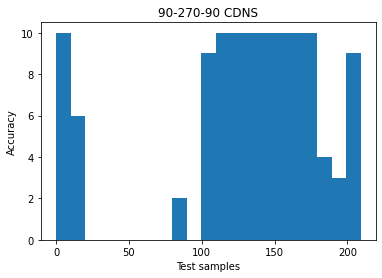

90-270-90 CERN
Average accuracy: 0.33
Longest accurate streak: 3


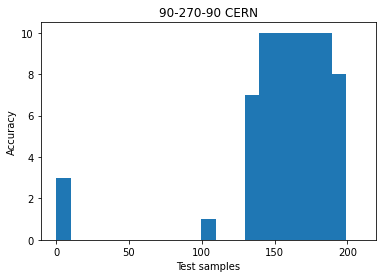

90-270-90 CHKP
Average accuracy: 0.46
Longest accurate streak: 0


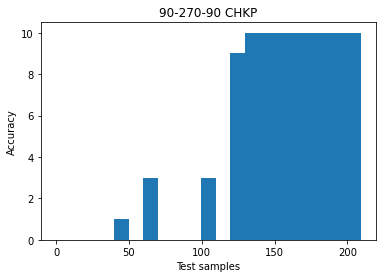

90-270-90 CSCO
Average accuracy: 0.87
Longest accurate streak: 112


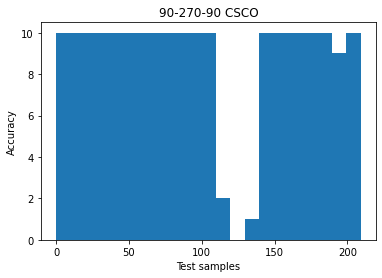

90-270-90 CTXS
Average accuracy: 0.9
Longest accurate streak: 185


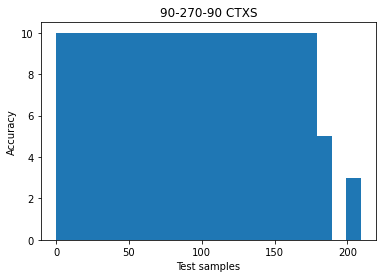

90-270-90 CTSH
Average accuracy: 0.57
Longest accurate streak: 91


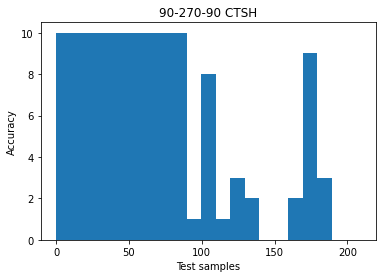

90-270-90 FB
Average accuracy: 0.57
Longest accurate streak: 43


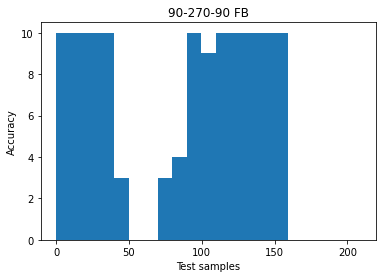

90-270-90 INTC
Average accuracy: 0.64
Longest accurate streak: 127


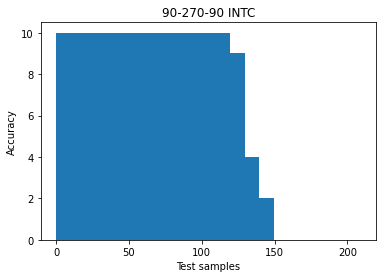

90-270-90 INTU
Average accuracy: 0.96
Longest accurate streak: 186


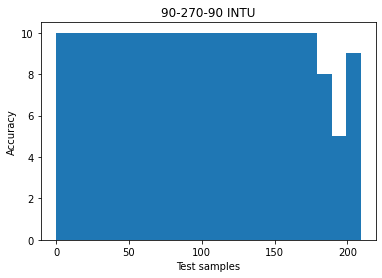

90-270-90 KLAC
Average accuracy: 0.56
Longest accurate streak: 16


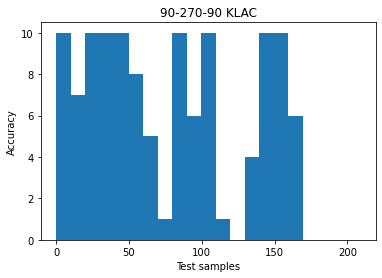

90-270-90 LRCX
Average accuracy: 0.36
Longest accurate streak: 15


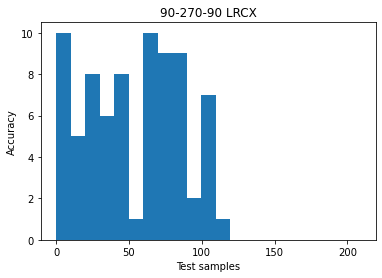

90-270-90 MXIM
Average accuracy: 0.7
Longest accurate streak: 99


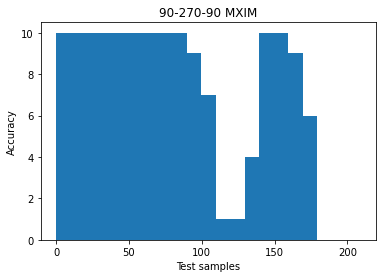

90-270-90 MCHP
Average accuracy: 0.46
Longest accurate streak: 16


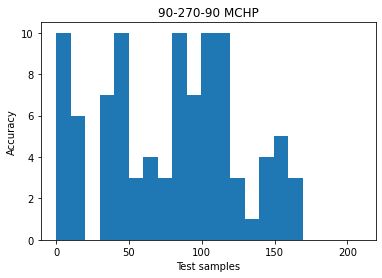

90-270-90 MU
Average accuracy: 0.67
Longest accurate streak: 56


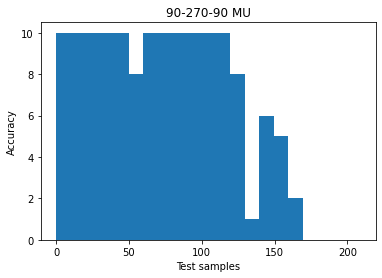

90-270-90 MSFT
Average accuracy: 1.0
Longest accurate streak: 0


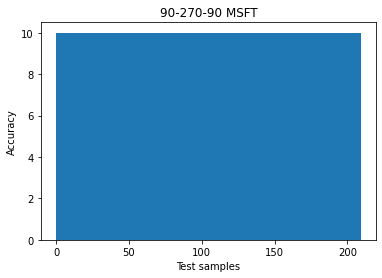

90-270-90 NTAP
Average accuracy: 0.97
Longest accurate streak: 195


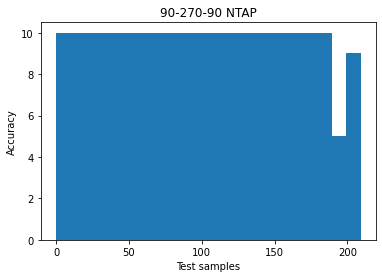

90-270-90 NTES
Average accuracy: 0.22
Longest accurate streak: 46


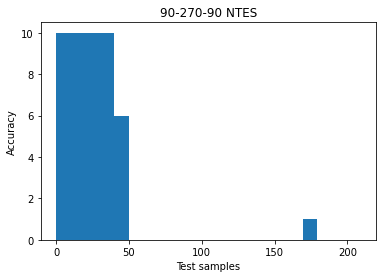

90-270-90 NVDA
Average accuracy: 0.84
Longest accurate streak: 56


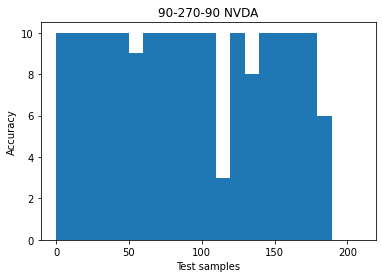

90-270-90 NXPI
Average accuracy: 0.27
Longest accurate streak: 52


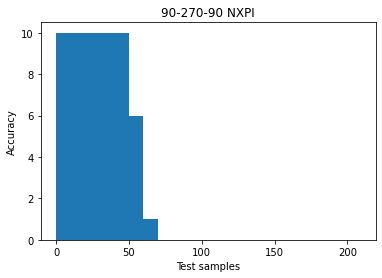

90-270-90 QCOM
Average accuracy: 0.56
Longest accurate streak: 42


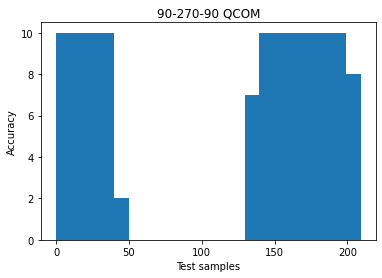

90-270-90 SWKS
Average accuracy: 0.23
Longest accurate streak: 0


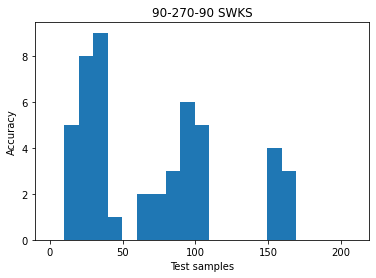

90-270-90 SYMC
Average accuracy: 0.06
Longest accurate streak: 0


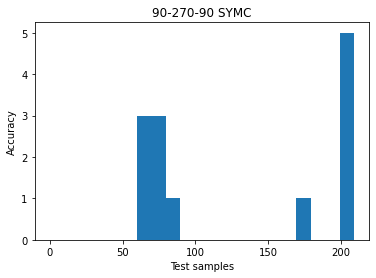

90-270-90 SNPS
Average accuracy: 0.68
Longest accurate streak: 26


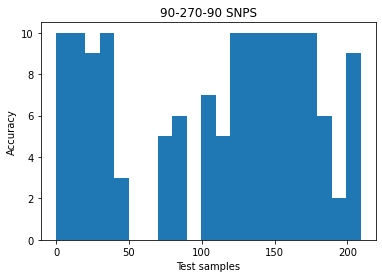

90-270-90 TXN
Average accuracy: 0.74
Longest accurate streak: 67


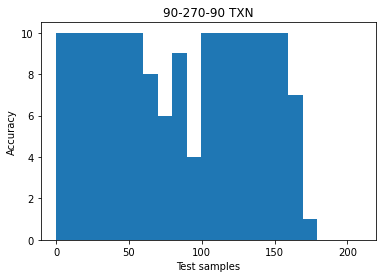

90-270-90 VRSN
Average accuracy: 0.97
Longest accurate streak: 17


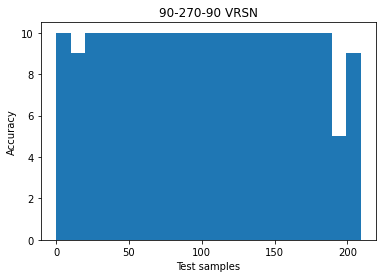

90-270-90 WDC
Average accuracy: 0.3
Longest accurate streak: 0


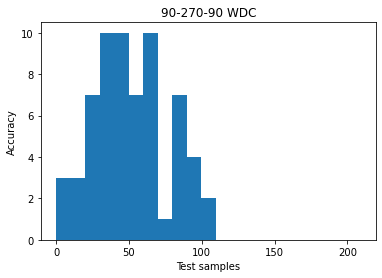

90-270-90 WDAY
Average accuracy: 0.87
Longest accurate streak: 112


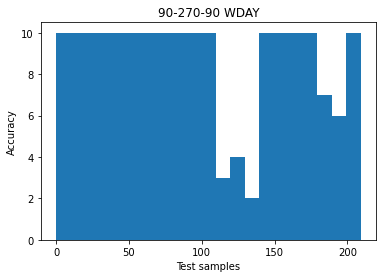

90-270-90 XLNX
Average accuracy: 0.55
Longest accurate streak: 14


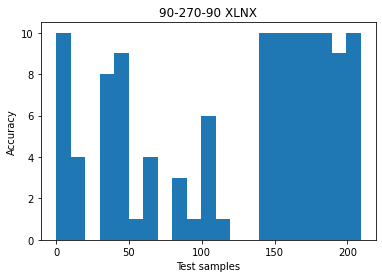

Evalutation for model: 20-10-270

20-10-270 ADBE
Average accuracy: 0.46
Longest accurate streak: 7


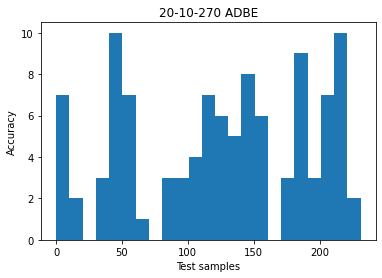

20-10-270 AMD
Average accuracy: 0.79
Longest accurate streak: 0


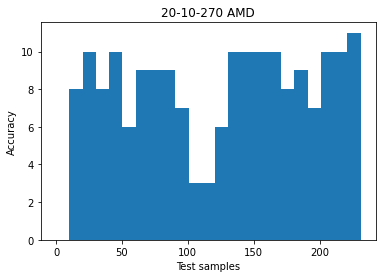

20-10-270 GOOGL
Average accuracy: 0.36
Longest accurate streak: 0


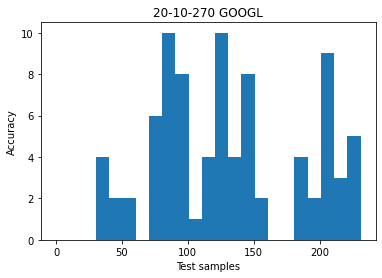

20-10-270 GOOG
Average accuracy: 0.36
Longest accurate streak: 0


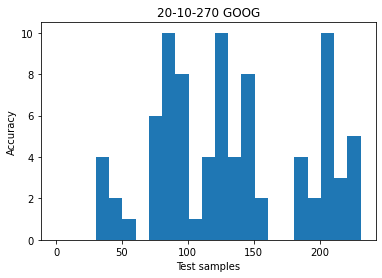

20-10-270 ADI
Average accuracy: 0.5
Longest accurate streak: 0


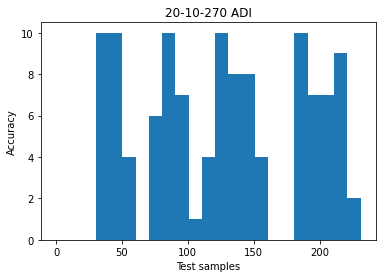

20-10-270 AAPL
Average accuracy: 0.55
Longest accurate streak: 5


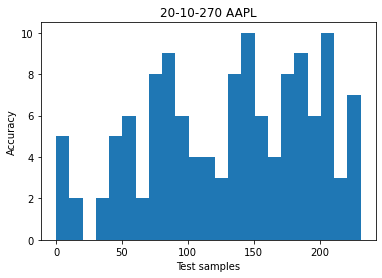

20-10-270 AMAT
Average accuracy: 0.57
Longest accurate streak: 0


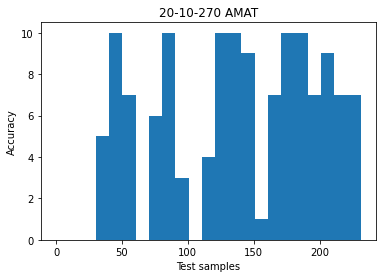

20-10-270 ASML
Average accuracy: 0.48
Longest accurate streak: 0


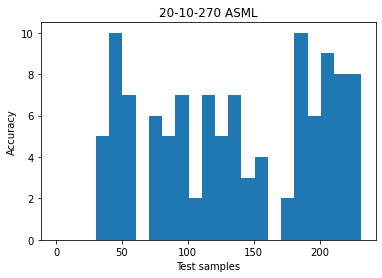

20-10-270 ADSK
Average accuracy: 0.46
Longest accurate streak: 0


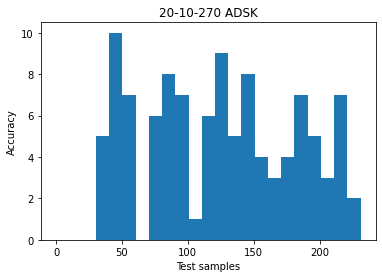

20-10-270 BIDU
Average accuracy: 0.58
Longest accurate streak: 0


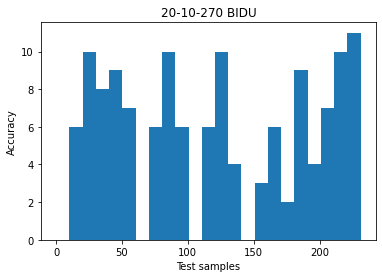

20-10-270 AVGO
Average accuracy: 0.49
Longest accurate streak: 2


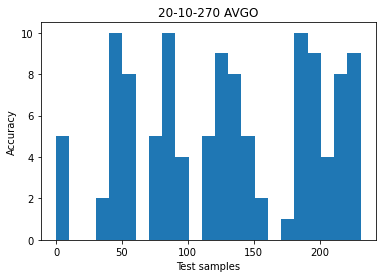

20-10-270 CDNS
Average accuracy: 0.6
Longest accurate streak: 0


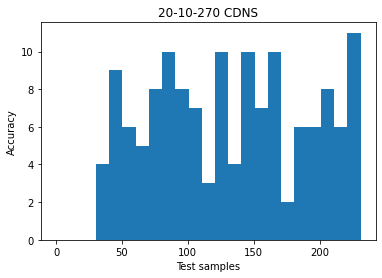

20-10-270 CERN
Average accuracy: 0.48
Longest accurate streak: 0


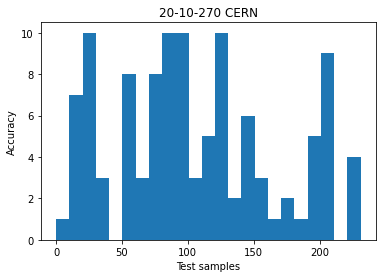

20-10-270 CHKP
Average accuracy: 0.53
Longest accurate streak: 0


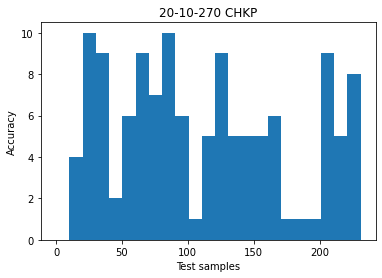

20-10-270 CSCO
Average accuracy: 0.31
Longest accurate streak: 0


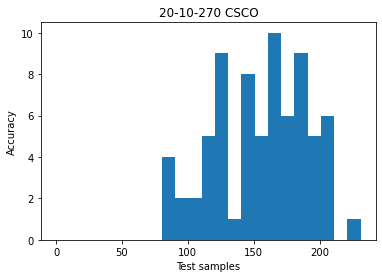

20-10-270 CTXS
Average accuracy: 0.36
Longest accurate streak: 0


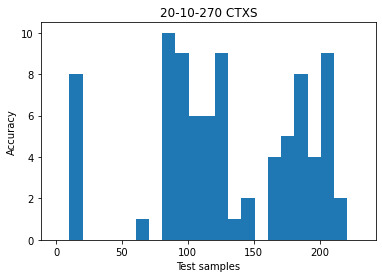

20-10-270 CTSH
Average accuracy: 0.42
Longest accurate streak: 0


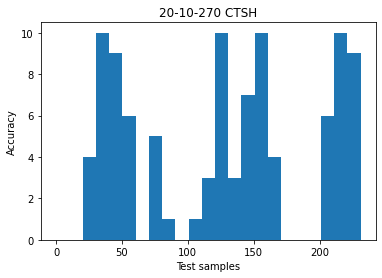

20-10-270 FB
Average accuracy: 0.41
Longest accurate streak: 3


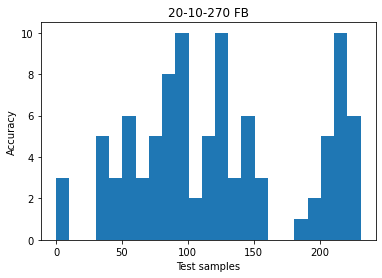

20-10-270 INTC
Average accuracy: 0.48
Longest accurate streak: 1


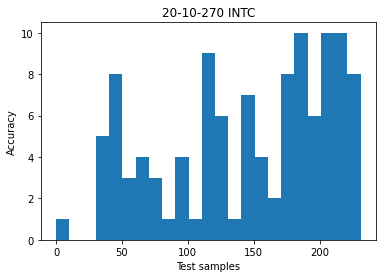

20-10-270 INTU
Average accuracy: 0.27
Longest accurate streak: 0


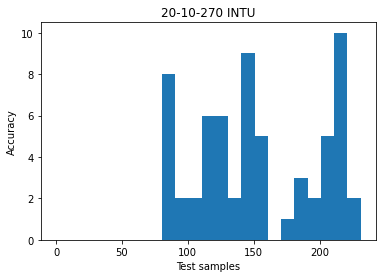

20-10-270 KLAC
Average accuracy: 0.53
Longest accurate streak: 0


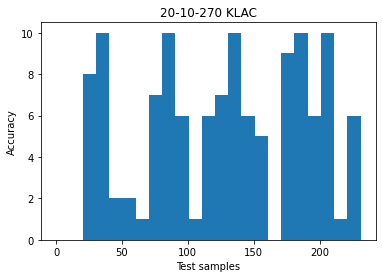

20-10-270 LRCX
Average accuracy: 0.56
Longest accurate streak: 0


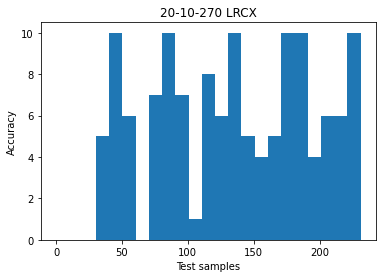

20-10-270 MXIM
Average accuracy: 0.38
Longest accurate streak: 0


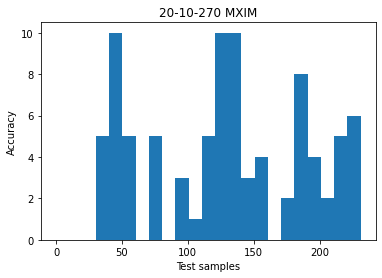

20-10-270 MCHP
Average accuracy: 0.59
Longest accurate streak: 0


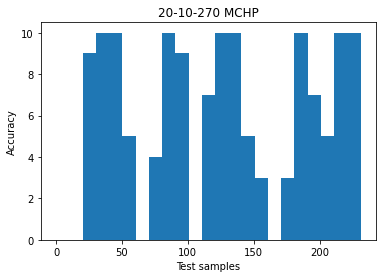

20-10-270 MU
Average accuracy: 0.53
Longest accurate streak: 0


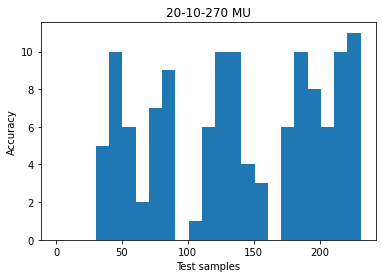

20-10-270 MSFT
Average accuracy: 0.47
Longest accurate streak: 0


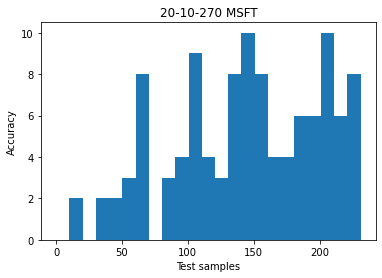

20-10-270 NTAP
Average accuracy: 0.26
Longest accurate streak: 0


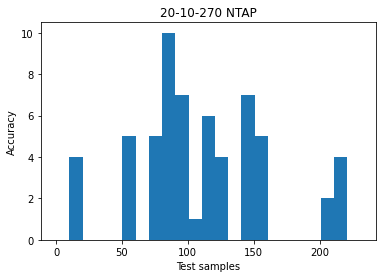

20-10-270 NTES
Average accuracy: 0.44
Longest accurate streak: 0


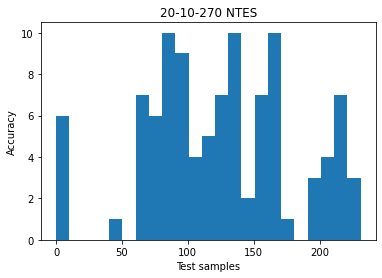

20-10-270 NVDA
Average accuracy: 0.39
Longest accurate streak: 0


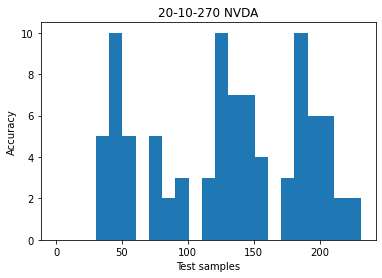

20-10-270 NXPI
Average accuracy: 0.42
Longest accurate streak: 0


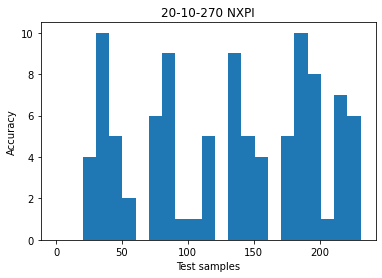

20-10-270 QCOM
Average accuracy: 0.66
Longest accurate streak: 9


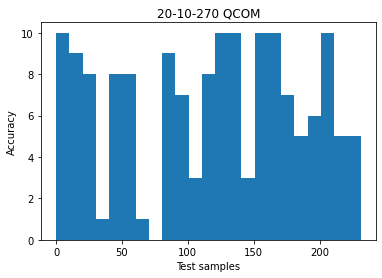

20-10-270 SWKS
Average accuracy: 0.43
Longest accurate streak: 7


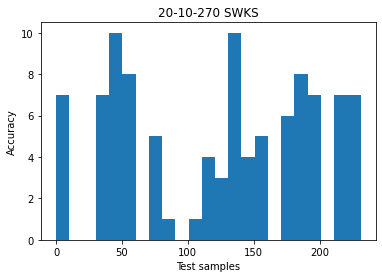

20-10-270 SYMC
Average accuracy: 0.61
Longest accurate streak: 44


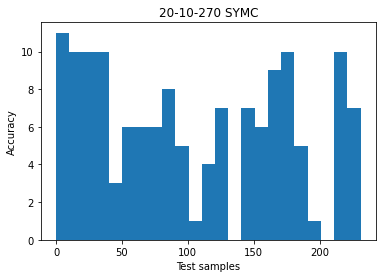

20-10-270 SNPS
Average accuracy: 0.53
Longest accurate streak: 0


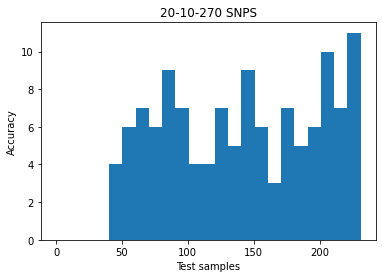

20-10-270 TXN
Average accuracy: 0.39
Longest accurate streak: 0


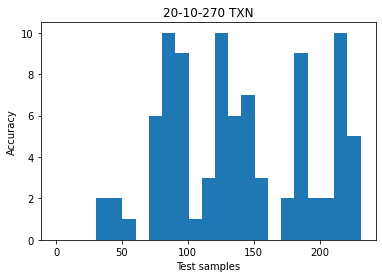

20-10-270 VRSN
Average accuracy: 0.37
Longest accurate streak: 0


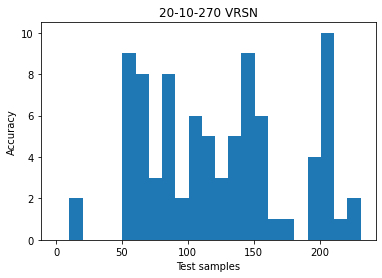

20-10-270 WDC
Average accuracy: 0.61
Longest accurate streak: 10


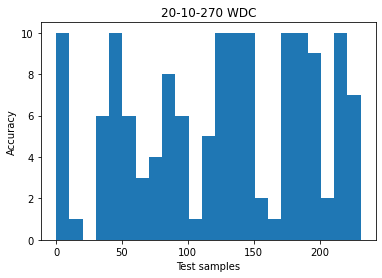

20-10-270 WDAY
Average accuracy: 0.59
Longest accurate streak: 0


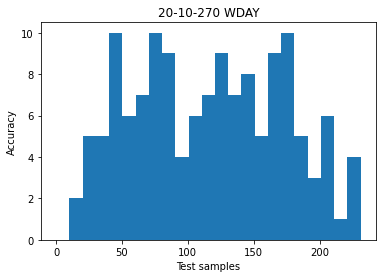

20-10-270 XLNX
Average accuracy: 0.59
Longest accurate streak: 0


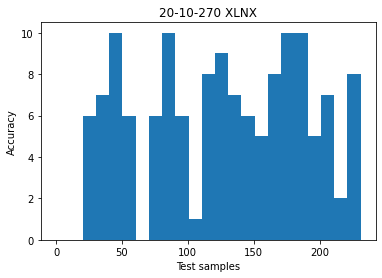

In [40]:
acc_streaks = {}
for mod, evals in evaluation.items():
    acc_streaks[mod] = {}
    acc_streaks[mod]['accuracy'] = []
    acc_streaks[mod]['streak'] = []
    
    print(f'Evalutation for model: {mod}\n')
    plt.figure()
    for symbol, accuracies in evals.items():
        print(mod+' '+symbol)
        acc = round(sum(accuracies)/len(accuracies),2)
        print(f'Average accuracy: {acc}')
        
        streak = 0
        for i, a in enumerate(accuracies):
            if a != 1: 
                streak = i
                break
        print(f'Longest accurate streak: {streak}')
        
        acc_streaks[mod]['accuracy'].append(acc)
        acc_streaks[mod]['streak'].append(streak)
        
        plt.subplot()
        plt.hist(range(len(accuracies)), int(len(accuracies)/10), weights=accuracies)
        plt.xlabel('Test samples')
        plt.ylabel('Accuracy')
        plt.title(mod+' tested on '+symbol)
        plt.show()
        
        

In [43]:
for mod, acc_streak in acc_streaks.items():
    print(f'Model: {mod}')
    acc = sum(acc_streak['accuracy'])/len(acc_streak['accuracy'])
    print(f'Average accuracy: {round(acc, 2)}')
    streak = sum(acc_streak['streak'])/len(acc_streak['streak'])
    print(f'Average longest accurate streak: {round(streak, 2)}')
    print()

Model: 270-90-10
Average accuracy: 0.76
Average longest accurate streak: 125.62

Model: 270-90-270
Average accuracy: 0.58
Average longest accurate streak: 27.69

Model: 90-270-10
Average accuracy: 0.46
Average longest accurate streak: 12.31

Model: 90-270-90
Average accuracy: 0.61
Average longest accurate streak: 52.82

Model: 20-10-270
Average accuracy: 0.48
Average longest accurate streak: 2.26

